<a href="https://colab.research.google.com/github/peppefdf/CSL_Gipuzkoa/blob/main/Aggregate_by_LatLon_coords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aggregated points based on distance:
       Lat    Lon                   geometry  A
0  43.1600 -2.190  POINT (-2.19000 43.16000)  1
1  43.1800 -2.180  POINT (-2.18000 43.18000)  1
2  43.1910 -2.190  POINT (-2.19000 43.19100)  2
3  43.2045 -2.345  POINT (-2.34500 43.20450)  3
4  43.2050 -2.305  POINT (-2.30500 43.20500)  1
5  43.2345 -2.341  POINT (-2.34100 43.23450)  1
6  43.2400 -2.234  POINT (-2.23400 43.24000)  2
7  43.2480 -2.364  POINT (-2.36400 43.24800)  2
8  43.2520 -2.234  POINT (-2.23400 43.25200)  3
9  43.2540 -2.254  POINT (-2.25400 43.25400)  2
Distance matrix:
              0             1             2             3             4  \
0      0.000000   3249.299148   4732.052806  18543.748359  14528.594102   
1   3249.299148      0.000000   2014.832420  18744.787767  14429.022377   
2   4732.052806   2014.832420      0.000000  17377.230717  12979.018163   
3  18543.748359  18744.787767  17377.230717      0.000000   4453.432327   
4  14528.594102  14429.022377  12979.018163

<ipython-input-173-10fb3657a46d>:99: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones_multipoly['geometry'] = zones_multipoly.geometry.buffer(0.001)


MULTIPOLYGON (((-2.304020076153945 43.20480058326885, -2.3040542744559755 43.20467500663033, -2.3041023121448294 43.204559348637346, -2.3041611183211015 43.20445567088906, -2.3042275927603937 43.20436485968815, -2.3042990351060366 43.20428679324336, -2.304373291539027 43.20422073644848, -2.304448774093772 43.204165635134125, -2.3045244407559418 43.20412030816139, -2.304599644129058 43.20408363263326, -2.3046740722343233 43.204054598090345, -2.304747636077887 43.20403236065949, -2.304820384158333 43.20401625642858, -2.304892506070606 43.20400578764758, -2.3049642005102426 43.20400063445927, -2.3050357985912218 43.20400063442708, -2.305107493057371 43.2040057875533, -2.305179614986521 43.204016256272446, -2.3052523630920803 43.204032360443016, -2.3053259271310806 43.20405459787157, -2.305400354917355 43.204083632216644, -2.3054755585359787 43.20412030777861, -2.3055512255139217 43.204165634874954, -2.305626707583482 43.20422073574277, -2.305700964670329 43.20428679302357, -2.305772406481

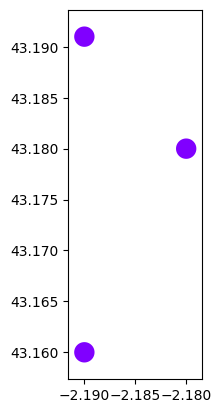

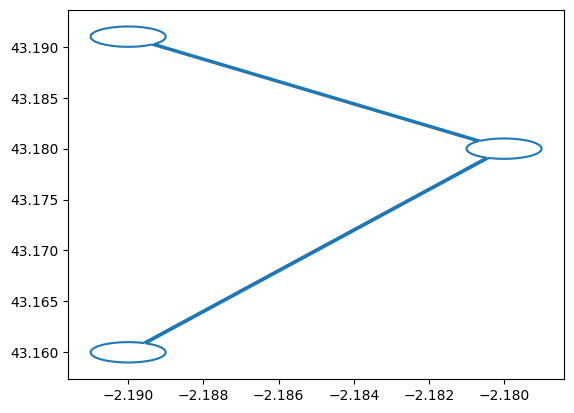

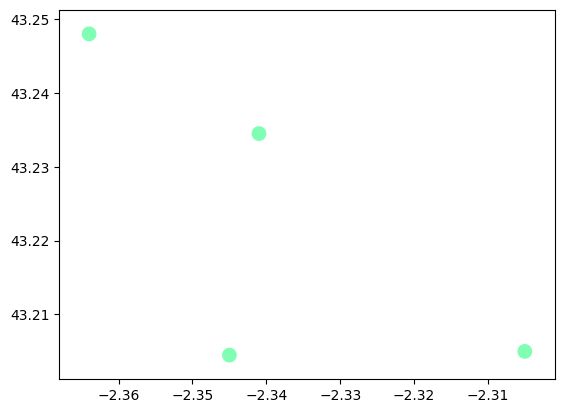

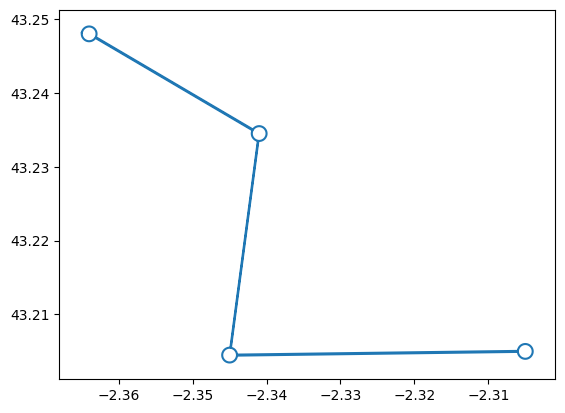

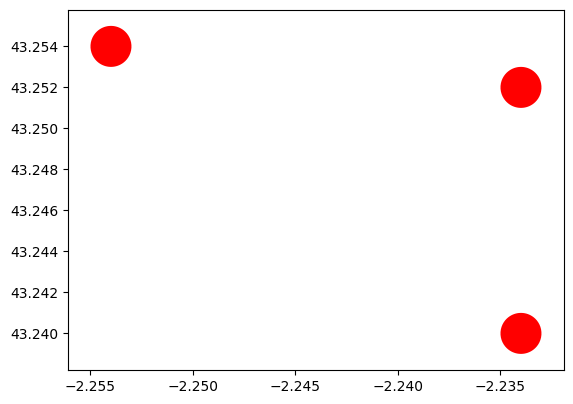

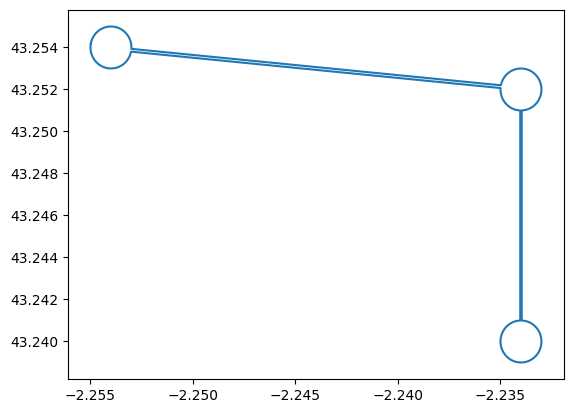

In [173]:
import pandas as pd
import geopy.distance
import numpy as np
import geopandas
import scipy

import folium
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt

from collections import defaultdict
from collections import Counter

#tol = 0.05 # <-- very case-specific
tol = 5000 # <-- very case-specific

d = {'A': [1, 1, 2, 3, 3, 2, 2, 1, 1, 2], 'Lat': [43.180, 43.2345, 43.248, 43.252, 43.2045, 43.254, 43.191, 43.205, 43.160, 43.240], 'Lon': [ -2.180, -2.341, -2.364, -2.234, -2.345, -2.254, -2.19, -2.305, -2.19, -2.234]}
df = pd.DataFrame(data=d)

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Lon, df.Lat), crs="EPSG:4326")

zones = gdf.dissolve(by=['Lat','Lon'], as_index=False) # aggregate data by coordinates
#zones.plot();
print('Aggregated points based on distance:')
print(zones)



zones = zones.to_crs(crs=3857)
zones.geometry = zones.buffer(0.001)
#print('Geodataframe with polygons?:')
#print(zones)
dist_matrix = zones.geometry.apply(lambda g: zones.distance(g))
print('Distance matrix:')
print(dist_matrix)
dist_matrix = np.array(dist_matrix)
list_el = np.argwhere(dist_matrix < tol)
print("The original list is : ", list(list_el))

# Record Similar tuple occurrences
# Using Counter() + map() + sorted
res = dict(Counter(tuple(ele) for ele in map(sorted, list_el)))
# printing result
print("The frequency of like tuples : " + str(res))
res = list(res.keys())
res = [res[i] for i in range(len(res)) if res[i][0]!=res[i][1]]
print('Diag. elements removed:', res)


def dfs(adj_list, visited, vertex, result, key):
    visited.add(vertex)
    result[key].append(vertex)
    for neighbor in adj_list[vertex]:
        if neighbor not in visited:
            dfs(adj_list, visited, neighbor, result, key)

adj_list = defaultdict(list)
for x, y in res:
    adj_list[x].append(y)
    adj_list[y].append(x)

result = defaultdict(list)
visited = set()
for vertex in adj_list:
    if vertex not in visited:
        dfs(adj_list, visited, vertex, result, vertex)

groups = list(result.values())
zones["Group"] = ""
zones["color"] = ""
group = 0
n_colors = len(groups)
cmap = cm.rainbow(np.linspace(0, 1, n_colors))

for i in groups:
   print('Group ',group, ' :',i)
   zones.loc[i,'Group'] = group
   zones.loc[i,'color'] = matplotlib.colors.rgb2hex(cmap[group])
   group+=1

print(zones)

from shapely.geometry import shape

"""
coords = [[zones[['Lon','Lat']].values.tolist()]]
print(coords)
zones['shape'] = shape({"type":"MultiPolygon", "coordinates": coords })
# Second step
gdf_poly = geopandas.GeoDataFrame(zones, geometry='shape')
"""
#zones = zones.to_crs(epsg=4326)
#zones = zones.to_crs(4326)
#zones['geometry'] = zones.geometry.buffer(0.001)
zones_multipoly = zones.dissolve(by='Group', as_index=False)
zones_multipoly = zones_multipoly.to_crs(epsg=4326)
zones_multipoly['geometry'] = zones_multipoly.geometry.buffer(0.001)
zones_multipoly = zones_multipoly.drop(columns=['A','Lat','Lon'])
#zones_multipoly['color'] = ['#C62828', '#87cefa', '#283593']
#zones_multipoly.simplify(tolerance=0.0001).plot(color=zones_multipoly['color'])
print(zones_multipoly)
#zones_multipoly.plot("Group", cmap="Set1")
#zones_multipoly.plot("Group", color= zones_multipoly['color'])

import shapely
from shapely import concave_hull
cont = 0
for i in zones_multipoly.geometry:
   #geopandas.GeoDataFrame(zones_multipoly).plot(legend=True, alpha=1.0, color= zones_multipoly['color'], aspect=1)
   print(i)
   df = geopandas.GeoDataFrame({'id':[cont],'geometry':[i]})
   df.plot(legend=True, alpha=1.0, color= zones_multipoly.loc[cont,'color'], aspect=1)
   pol = concave_hull(zones_multipoly['geometry'][cont])
   coords_polygon = [[i[0],i[1]] for i in list(pol.exterior.coords)]
   print(coords_polygon)
   xs, ys = zip(*coords_polygon) #create lists of x and y values
   plt.figure()
   plt.plot(xs,ys)
   cont+=1
#zones_multipoly.plot()
#zones_multipoly.simplify(tolerance=0.0001).plot(color=zones_multipoly['color'])
plt.show()


mapPlot = folium.Map(location=[43.23450, -2.34100], zoom_start=12)
for lon, lat, c in zip(zones['Lon'], zones['Lat'], zones['color']):
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        fill_color=c,
        color = c,
        fill=True,
        fill_opacity=0.7
        ).add_to(mapPlot)
mapPlot

